In [21]:
import pandas as pd

# 1. Autenticar o GCP

In [12]:
from google.colab import auth
auth.authenticate_user()

Especificando o projeto:

In [19]:
#tirado do BigQuery
project_id ='radiant-poet-316918'

#2. Conectar ao BigQuery

In [17]:
from google.cloud import bigquery

In [20]:
# Criando um objeto "Client"
client = bigquery.Client(project=project_id)

## Client, Dataset, Table and Jobs

**Client** manages connections to the BigQuery API. Use the client methods to run jobs (such as a QueryJob via query()) and manage resources.

**Dataset** represents a collection of tables.

**Table** represents a single “relation”.

**Jobs do BigQuery** Jobs são ações executadas pelo BigQuery em seu nome para *carregar*, *exportar*, *consultar* ou *copiar* dados.

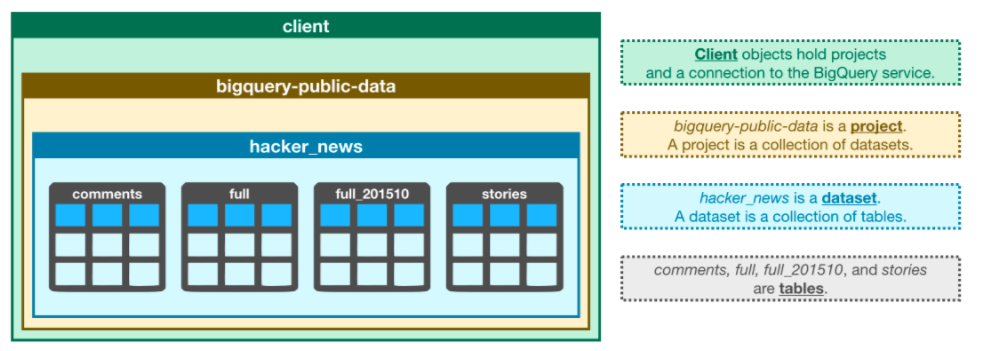

#Acessar o Data Set

criando uma referência para o dataset para dar fetch. A ref é como o endereço do dataset, enquanto a   var 'dataset' que defino abaixo é realmente o dataset copiado para mexer no python

In [ ]:
#ref para a tabela 'chicago_crime'
dataset_ref = client.dataset('chicago_crime', project='bigquery-public-data')

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

#ref para a tablea 'hacker news'
dataset_hackernews_ref = client.dataset('hacker_news', project = 'bigquery-public-data')
# API request - fetch the dataset
dataset_hackernews = client.get_dataset(dataset_hackernews_ref)


#Lista de tabelas

In [ ]:
#criando var tables com uma lista das tabelas dentro do dataset 
tables = list(client.list_tables(dataset))

#loop para printar nomes das tabelas
for table in tables:
  print(table.table_id)

# para a tabela hacker_news, usaria o código abaixo
#tables = list(client.list_tables(dataset_hackernews))

crime


In [ ]:
tables = list(client.list_tables(dataset)) 

# Get a list of available tables 
list_of_tables = [table.table_id for table in tables]
# Print your answer
print(list_of_tables)

In [ ]:
# Print number of tables in the dataset
print(len(tables))

1


#Copiar tabela

In [ ]:
# criando uma ref para a tabela "crime" dentro do dataset
table_ref = dataset_ref.table("crime")

# API request - fetch the table
table = client.get_table(table_ref)

#Checar table Schema

**Table schema** The structure of a table is called its schema. 

In [ ]:
table.schema

Each SchemaField tells us about a specific column (which we also refer to as a field). In order, the information is:

The **name** of the column

The **field type** (or datatype) in the column

The **mode** of the column ('NULLABLE' means that a column allows NULL values, and is the default)


A **description** of the data in that column

#Mostrar o dado em um dataframe

We can use the list_rows() method to check just the first five lines of of the full table to make sure this is right. (Sometimes databases have outdated descriptions, so it's good to check.) This returns a BigQuery RowIterator object that can quickly be converted to a pandas DataFrame with the to_dataframe() method.

In [ ]:
client.list_rows(table, max_results = 2).to_dataframe()


,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,11243020,HZ184094,2016-03-11 23:00:00+00:00,052XX N ST LOUIS AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE PORCH/HALLWAY,False,False,1712,17,39,13,02,NaN,NaN,2016,2018-03-01 15:54:55+00:00,NaN,NaN,None
1,10296282,HY484436,2015-11-01 02:50:00+00:00,059XX S CENTRAL AVE,1335,CRIMINAL TRESPASS,TO AIRPORT,AIRPORT TERMINAL LOWER LEVEL - SECURE AREA,True,False,813,8,23,64,26,1140061.0,1864871.0,2015,2018-02-10 15:50:01+00:00,41.785298,-87.762022,"(41.785298412, -87.762021668)"


The list_rows() method will also let us look at just the information in a specific column. If we want to see the first five entries in the by column, for example, we can do that!

In [ ]:
# Preview the first five entries in the "by" column of the "full" table
client.list_rows(table, selected_fields=table.schema[7:8], max_results=3).to_dataframe()

,location_description
0,RESIDENCE PORCH/HALLWAY
1,AIRPORT TERMINAL LOWER LEVEL - SECURE AREA
2,STREET


# QUERIES - SELECT, FROM E WHERE

Using the OpenAQ dataset, a dataset with only one table with data about the air quality in diferent locations around the globe, let's set up a query for study

In [ ]:
# Query to select all the items from the "city" column where the "country" column is 'US'
query = """
        SELECT city
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE country = 'US'
        """

Note that when writing an SQL query, the argument we pass to FROM is not in single or double quotation marks (' or "). It is in backticks (`).

We begin by setting up the query with the query() method.

In [ ]:
# Set up the query
query_job = client.query(query)

Next, we run the query and convert the results to a pandas DataFrame.

In [ ]:
# API request - run the query, and return a pandas DataFrame
us_cities = query_job.to_dataframe()      

#us_cities é um dataframe com as cidades do US que constam na tabela global_air_quality

In [ ]:
# What five cities have the most measurements?
us_cities.city.value_counts().head()

Phoenix-Mesa-Scottsdale                     88
Houston                                     82
Los Angeles-Long Beach-Santa Ana            68
Riverside-San Bernardino-Ontario            60
New York-Northern New Jersey-Long Island    60
Name: city, dtype: int64

##Job_config

###dry_config: Estimando o tamanho (custo) de uma query antes de executar

Each user from Kaggle has up to 5 TB to scan from bigquery for free ever 30 days. Therefore, you have to be carefull to not reach the limit

To begin,you can estimate the size of any query before running it. Here is an example using the (very large!) Hacker News dataset. To see how much data a query will scan, we create a **QueryJobConfig** object and set the **dry_run parameter to True**.

In [ ]:
# Query to get the score column from every row where the type column has value "job"
query = """
        SELECT score, title
        FROM `bigquery-public-data.hacker_news.full`
        WHERE type = "job" 
        """

# Create a QueryJobConfig object to estimate size of query without running it
dry_run_config = bigquery.QueryJobConfig(dry_run=True)

# API request - dry run query to estimate costs
dry_run_query_job = client.query(query, job_config=dry_run_config)

print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))

This query will process 471484285 bytes.


###safe_config: Limitando tamanho de Query

you can also specify a parameter when running the query to limit how much data you are willing to scan. Here's an example with a low limit

In [ ]:
# Only run the query if it's less than 1 GB
ONE_GB = 1000*1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_GB)

# Set up the query (will only run if it's less than 1 GB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
safe_query_job.to_dataframe()

,score,title
0,1.0,Join a Rocket Ship. Instacart is hiring Senior...
1,1.0,Mixpanel: We're hiring and here's where we're at.
2,1.0,Citus Data is hiring a product marketer
3,1.0,Five Stars (Winter 2011) has really challengin...
4,1.0,FutureAdvisor (YC S10): Help middle-class fami...
...,...,...
14117,2.0,Airbnb - Backend Engineer
14118,4.0,Mixpanel Analytics looking for senior software...
14119,5.0,Airbnb - User Experience Designer
14120,39.0,Posterous is hiring UI Designers and Software ...


In [ ]:
# API request - try to run the query, and return a pandas DataFrame
job_post_scores = safe_query_job.to_dataframe()

# Print average score for job posts
job_post_scores.score.mean()

1.8183699105889308

In [ ]:
# View top few rows of results
print(job_post_scores.head())

   score                                              title
0    1.0  Join a Rocket Ship. Instacart is hiring Senior...
1    1.0  Mixpanel: We're hiring and here's where we're at.
2    1.0            Citus Data is hiring a product marketer
3    1.0  Five Stars (Winter 2011) has really challengin...
4    1.0  FutureAdvisor (YC S10): Help middle-class fami...


In [ ]:
job_post_scores.head()

,score,title
0,1.0,Join a Rocket Ship. Instacart is hiring Senior...
1,1.0,Mixpanel: We're hiring and here's where we're at.
2,1.0,Citus Data is hiring a product marketer
3,1.0,Five Stars (Winter 2011) has really challengin...
4,1.0,FutureAdvisor (YC S10): Help middle-class fami...


#GROUP BY, HAVING and COUNT

**COUNT()** is an example of an aggregate function, which takes many values and returns one. (Other examples of aggregate functions include SUM(), AVG(), MIN(), and MAX().)

**GROUP BY** takes the name of one or more columns, and treats all rows with the same value in that column as a single group when you apply aggregate functions like COUNT().

**HAVING** is used in combination with GROUP BY to ignore groups that don't meet certain criteria.

So this query, for example, will only include groups that have more than one ID in them.

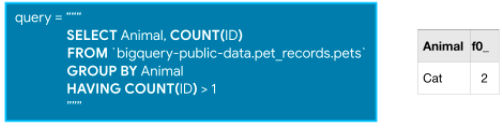



The **WHERE** clause cannot contain aggregate functions

In [ ]:
# Query to select comments that received more than 10 replies
query_popular = """
                SELECT parent, COUNT(1)
                FROM `bigquery-public-data.hacker_news.comments`
                GROUP BY parent
                HAVING COUNT(1) > 10
                """

In [ ]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_popular, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
popular_comments = query_job.to_dataframe()

# Print the first five rows of the DataFrame
popular_comments.head()

,parent,f0_
0,801208,56
1,5463210,55
2,6455391,67
3,8336025,50
4,3785277,85


Through python, something like that can be done with function `value.counts()`

In [51]:
us_cities.city.value_counts()

PRINCE EDWARD    1
Lawton           1
JACKSON          1
St. Joseph       1
Tupelo           1
                ..
Kingsville       1
Wilmington       1
La Grande        1
YUKON-KOYUKUK    1
CUYAHOGA         1
Name: city, Length: 781, dtype: int64

#ORDER BY

##DATE

Next, we'll talk about dates, because they come up very frequently in real-world databases. There are two ways that dates can be stored in BigQuery: as a **DATE** or as a **DATETIME**.

The DATE format has the year first, then the month, and then the day. It looks like this:

    YYYY-[M]M-[D]D

YYYY: Four-digit year

[M]M: One or two digit month

[D]D: One or two digit day

So 2019-01-10 is interpreted as January 10, 2019.

The DATETIME format is like the date format ... but with time added at the end.

##EXTRACT


Often you'll want to look at part of a date, like the year or the day. You can do this with EXTRACT.

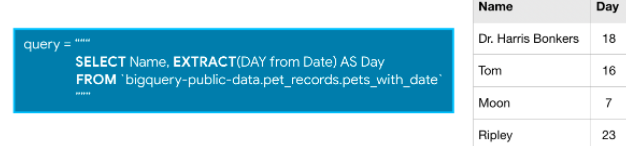

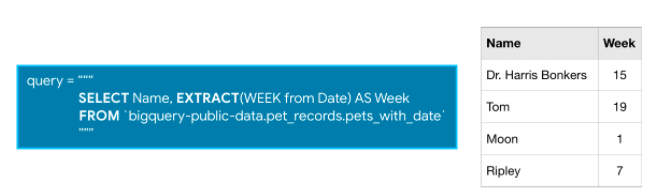

Consider only the rows in the dataset corresponding to indicator code SE.XPD.TOTL.GD.ZS, and write a query that returns the average value in the value column for each country in the dataset between the years 2010-2017 (including 2010 and 2017 in the average).

In [ ]:
country_spend_pct_query = """
                          SELECT country_name, AVG(value) as avg_ed_spending_pct
                          FROM `bigquery-public-data.world_bank_intl_education.international_education`
                          WHERE indicator_code = "SE.XPD.TOTL.GD.ZS"
                          AND year > 2009
                          AND year < 2018
                          GROUP BY country_name
                          ORDER BY avg_ed_spending_pct DESC
                          """
​
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
country_spend_pct_query_job = client.query(country_spend_pct_query, job_config=safe_config)
​
# API request - run the query, and return a pandas DataFrame
country_spending_results = country_spend_pct_query_job.to_dataframe()
​
# View top few rows of results
print(country_spending_results.head())
​

Write a query below that selects the indicator code and indicator name for all codes with at least 175 rows in the year 2016.

Requirements:

-You should have one row for each indicator code.

-The columns in your results should be called indicator_code, indicator_name, and num_rows.

-Only select codes with 175 or more rows in the raw database (exactly 175 rows would be included).

-To get both the indicator_code and indicator_name in your resulting DataFrame, you need to include both in your SELECT statement (in addition to a COUNT() aggregation). This requires you to include both in your GROUP BY clause.

-Order from results most frequent to least frequent.

In [ ]:
# Your code goes here
code_count_query = """

                    SELECT indicator_code, indicator_name, COUNT(1) AS num_rows
                    FROM `bigquery-public-data.world_bank_intl_education.international_education`
                    WHERE year = 2016
                    GROUP BY indicator_code, indicator_name
                    HAVING COUNT(1)>=175
                    ORDER BY COUNT(1) DESC
                    
                    """

# Set up the query
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
code_count_query_job = client.query(code_count_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
code_count_results = code_count_query_job.to_dataframe()

# View top few rows of results
print(code_count_results.head())


# WITH and AS

On its own, **AS** is a convenient way to clean up the data returned by your query. It's even more powerful when combined with **WITH** in what's called a "common table expression".

A common table expression (or **CTE**) is a temporary table that you return within your query. **CTEs** are helpful for splitting your queries into readable chunks, and you can write queries against them.

In [ ]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

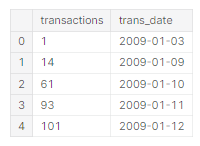

##plot simples

Since they're returned sorted, we can easily plot the raw results to show us the number of Bitcoin transactions per day over the whole timespan of this dataset.

In [ ]:
transactions_by_date.set_index('trans_date').plot()

##Example

Write a query that counts the number of trips in each year.

Your results should have three columns:

1. `year` - the year of the trips

2. `month` - the month of the trips

3. `num_trips` - the number of trips per month in each year

You'd like to take a closer look at rides from 2017 until now. 

In [ ]:
# Your code goes here
rides_per_month_query = """
                        WITH time AS (
                            SELECT  EXTRACT(MONTH FROM trip_start_timestamp) as month, 
                                    EXTRACT(YEAR FROM trip_start_timestamp) as year
                            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                        )
                        SELECT year, month, COUNT(1) AS num_trips
                        FROM time
                        GROUP BY month, year
                        HAVING year >=2017
                        ORDER BY year, month
                        """ 

# Set up the query
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_month_query_job = client.query(rides_per_month_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
rides_per_month_result = rides_per_month_query_job.to_dataframe() # Your code goes here

# View results
print(rides_per_month_result)


In [ ]:
speeds_query = """
               WITH RelevantRides AS
               (
                   SELECT   EXTRACT(HOUR FROM trip_start_timestamp) as hour_of_day, 
                            trip_seconds, 
                            trip_miles
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE trip_start_timestamp > '2017-01-01' 
                   AND   trip_start_timestamp < '2017-07-01'
                   AND   trip_seconds > 0 
                   AND   trip_miles > 0
               )
               SELECT hour_of_day, COUNT(1) as num_trips, (3600 * SUM(trip_miles) / SUM(trip_seconds)) AS avg_mph
               FROM RelevantRides
               GROUP BY hour_of_day
               ORDER BY hour_of_day,avg_mph
               """

#JOIN

##Example

Write a new query that has a single row for each user who answered at least one question with a tag that includes the string "bigquery". Your results should have two columns:

user_id - contains the owner_user_id column from the posts_answers table
number_of_answers - contains the number of answers the user has written to "bigquery"-related questions

In [ ]:
bigquery_experts_query = """

                        SELECT  a.owner_user_id AS user_id, 
                                COUNT(1) AS number_of_answers
                        FROM       `bigquery-public-data.stackoverflow.posts_questions` AS q 
                            INNER JOIN `bigquery-public-data.stackoverflow.posts_answers`   AS a 
                            ON q.id = a.parent_id
                        WHERE q.tags LIKE '%bigquery%'
                        GROUP BY user_id
                        ORDER BY number_of_answers

                        """

# Set up the query
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
bigquery_experts_query_job = client.query(bigquery_experts_query, job_config = safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
bigquery_experts_results = bigquery_experts_query_job.to_dataframe() # Your code goes here

# Preview results
print(bigquery_experts_results.head())

## LEFT, RIGHT and FULL JOIN

Replacing INNER JOIN with **LEFT JOIN** returns all rows where the two tables have matching entries, along with all of the rows in the left table (whether there is a match or not).

"left" refers to the table that appears before the JOIN in the query. 

"Right" refers to the table that is after the JOIN.

A **FULL JOIN** returns all rows from both tables. Note that in general, any row that does not have a match in both tables will have NULL entries for the missing values. You can see this in the image below.

In [ ]:
# Query to select all stories posted on January 1, 2012, with number of comments
join_query = """
             WITH c AS
             (
             SELECT parent, COUNT(*) as num_comments
             FROM `bigquery-public-data.hacker_news.comments` 
             GROUP BY parent
             )
             SELECT s.id as story_id, s.by, s.title, c.num_comments
             FROM `bigquery-public-data.hacker_news.stories` AS s
             LEFT JOIN c
             ON s.id = c.parent
             WHERE EXTRACT(DATE FROM s.time_ts) = '2012-01-01'
             ORDER BY c.num_comments DESC
             """

# Run the query, and return a pandas DataFrame
join_result = client.query(join_query).result().to_dataframe()
join_result.head()


The query below pulls information from the stories and comments tables to create a table showing all stories posted on January 1, 2012, along with the corresponding number of comments. We use a LEFT JOIN so that the results include stories that didn't receive any comments.

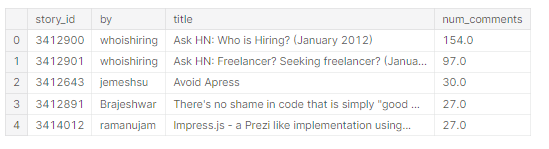

Since the results are ordered by the num_comments column, stories without comments appear at the end of the DataFrame. (Remember that NaN stands for "not a number".)

`join_result.tail()`

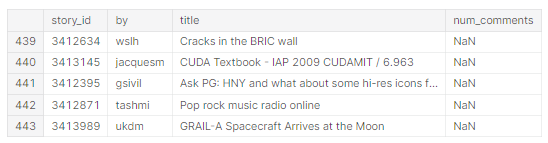

say you're interested in understanding users who joined the site in January 2019. You want to track their activity on the site: when did they post their first questions and answers, if ever?

Write a query that returns the following columns:

- `id` - the IDs of all users who created Stack Overflow accounts in January 2019 (January 1, 2019, to January 31, 2019, inclusive)
- `q_creation_date` - the first time the user posted a question on the site; if the user has never posted a question, the value should be null
- `a_creation_date` - the first time the user posted an answer on the site; if the user has never posted a client.list_rows(table, max_results = 2).to_dataframe(), the value should be null


Note that questions and answers posted after January 31, 2019, should still be included in the results. And, all users who joined the site in January 2019 should be included (even if they have never posted a question or provided an answer).

The query from the previous question should be a nice starting point to answering this question! You'll need to use the posts_answers and posts_questions tables. You'll also need to use the users table from the Stack Overflow dataset. The relevant columns from the users table are id (the ID of each user) and creation_date (when the user joined the Stack Overflow site, in DATETIME format).

In [ ]:
#criando var tables com uma lista das tabelas dentro do dataset 
tables = list(client.list_tables(dataset))

#loop para printar nomes das tabelas
for table in tables:
  print(table.table_id)

In [ ]:
three_tables_query = """

                    SELECT  u.id as id,
                            MIN(q.creation_date) AS q_creation_date,
                            MIN(a.creation_date) AS a_creation_date
                     FROM `bigquery-public-data.stackoverflow.users` AS u
                            LEFT JOIN `bigquery-public-data.stackoverflow.posts_answers` AS a
                            ON u.id = a.owner_user_id
                                LEFT JOIN `bigquery-public-data.stackoverflow.posts_questions` AS q
                                ON q.owner_user_id = u.id
                     WHERE u.creation_date >= '2019-01-01' and u.creation_date < '2019-02-01'
                     GROUP BY id
                     """

#UNION

JOINs horizontally combine results from different tables. If you instead would like to vertically concatenate columns, you can do so with a **UNION**.

In [ ]:
query = """

        SELECT Age FROM `bigquery-public-data.pet_records.pets`
        UNIOM ALL
        SELECT Age FROM `bigquery-public-data.pet_records.owners`

        """

Note that with a UNION, the data types of both columns must be the same, but the column names can be different. 

We use **UNION ALL** to include duplicate values. If you'd like to drop duplicate values, you need only change UNION ALL in the query to **UNION DISTINCT**.

In [43]:
all_users_query =   """

                   SELECT q.owner_user_id 
                  FROM `bigquery-public-data.stackoverflow.posts_questions` AS q
                  WHERE EXTRACT(DATE FROM q.creation_date) = '2019-01-01'
                  UNION DISTINCT
                  SELECT a.owner_user_id
                  FROM `bigquery-public-data.stackoverflow.posts_answers` AS a
                  WHERE EXTRACT(DATE FROM a.creation_date) = '2019-01-01'
                  
                  """

#Analytic Window Functions 

 Unlike aggregate functions, analytic functions return a (potentially different) value for each row in the original table.

 Analytic functions allow us to perform complex calculations with relatively straightforward syntax. For instance, we can quickly calculate moving averages and running totals, among other quantities.

## OVER Clauses

All analytic functions have an OVER clause, which defines the sets of rows used in each calculation. The OVER clause has three (optional) parts:

1. The **PARTITION BY** clause divides the rows of the table into different groups. In the query above, we divide by id so that the calculations are separated by runner.

2. The **ORDER BY** clause defines an ordering within each partition. In the sample query, ordering by the date column ensures that earlier training sessions appear first.

3. The final clause (`ROWS BETWEEN 1 PRECEDING AND CURRENT ROW`) is known as a **window frame clause**. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window. (*Actually, analytic functions are sometimes referred to as **analytic window functions** or simply **window functions**!*)

There are many ways to write **window frame clauses**:

- `ROWS BETWEEN 1 PRECEDING AND CURRENT ROW` - the previous row and the current row.

- `ROWS BETWEEN 3 PRECEDING AND 1 FOLLOWING` - the 3 previous rows, the current row, and the following row.

- `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING` - all rows in the partition.

Of course, this is not an exhaustive list, and you can imagine that there are many more options! In the code below, you'll see some of these clauses in action.




## 1) Analytic **aggregate** functions

Aggregate functions take all of the values within the window as input and return a single value.

- **MIN()** (or **MAX()**) - Returns the minimum (or maximum) of -input values
- **AVG()** (or **SUM()**) - Returns the average (or sum) of input values
- **COUNT()** - Returns the number of rows in the input

The id column identifies each runner, the date column holds the day of the training session, and time shows the time (in minutes) that the runner dedicated to training. Say we'd like to calculate a moving average of the training times for each runner, where we always take the average of the current and previous training sessions. We can do this with the following query:

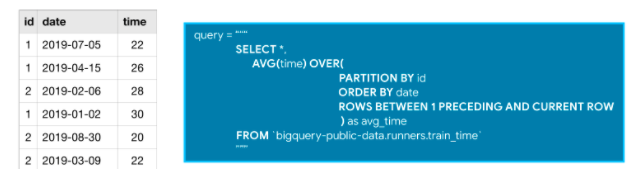

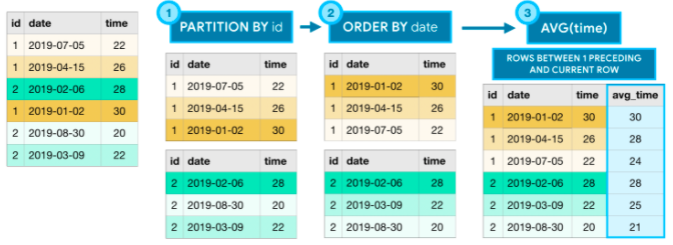

##2) Analytic **navigation** function

Navigation functions assign a value based on the value in a (usually) different row than the current row.

- **FIRST_VALUE()** (or **LAST_VALUE()**) - Returns the first (or last) value in the input
- **LEAD()** (and **LAG()**) - Returns the value on a subsequent (or preceding) row

##3) Analytic **numbering** functions



Numbering functions assign integer values to each row based on the ordering.

- **ROW_NUMBER()** - Returns the order in which rows appear in the input (starting with 1)
- **RANK()** - All rows with the same value in the ordering column receive the same rank value, where the next row receives a rank value which increments by the number of rows with the previous rank value.

## Examples

###Aggregate function (SUM())

We'll work with the San Francisco Open Data dataset, bikeshare_trips table.

We can use an analytic function to calculate the cumulative number of trips for each date in 2015.

In [ ]:
# Query to count the (cumulative) number of trips per day
num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) AS trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  SELECT *,
                      SUM(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                               ) AS cumulative_trips
                      FROM trips_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

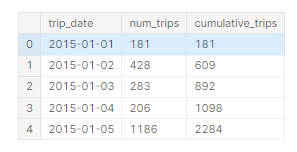

###Navigation Function 

#### Exp 1 (LAST_VALUE())

The next query tracks the stations where each bike began (in start_station_id) and ended (in end_station_id) the day on October 25, 2015.

In [ ]:
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()

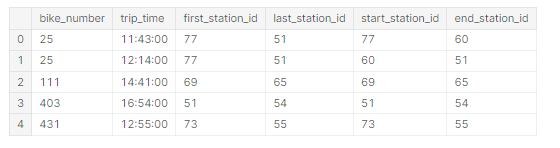

####Exp 2 (LAG())

Write a query for the columns `taxi_id`, `trip_start_timestamp`, and `trip_end_timestamp` and an additional `prev_break` column that shows the length of the break (in minutes) that the driver had before each trip started (this corresponds to the time between trip_start_timestamp of the current trip and trip_end_timestamp of the previous trip).

In [ ]:
break_time_query = """
                   SELECT taxi_id,
                       trip_start_timestamp,
                       trip_end_timestamp,
                       TIMESTAMP_DIFF(
                           trip_start_timestamp, 
                           LAG(trip_end_timestamp) 
                               OVER (
                                    PARTITION BY taxi_id 
                                    ORDER BY trip_start_timestamp), 
                           MINUTE) as prev_break
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE DATE(trip_start_timestamp) = '2017-05-01' 
                   """

###Numbering Function (RANK())

Write a query to return the columns `pickup_community_area`, `trip_start_timestamp`, and `trip_end_timestamp` and an additional column called `trip_number` which shows the order in which the trips were taken from their respective community areas. 

So, the first trip of the day originating from community area 1 should receive a value of 1; the second trip of the day from the same area should receive a value of 2. Likewise, the first trip of the day from community area 2 should receive a value of 1, and so on.

In [ ]:
trip_number_query = """
                    SELECT pickup_community_area,
                        trip_start_timestamp,
                        trip_end_timestamp,
                        RANK() 
                            OVER(
                                 PARTITION BY pickup_community_area
                                 ORDER  BY trip_start_timestamp)
                            as trip_number
                    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                    WHERE DATE(trip_start_timestamp) = '2017-05-01'
                    """

#Nested data

Nested columns have type **STRUCT** (or type **RECORD**)

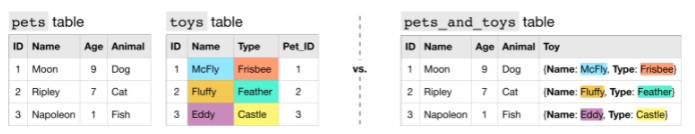

In this case, all of the information from the toys table is collapsed into a single column (the `Toy` column in the pets_and_toys table). We refer to the `Toy` column in the pets_and_toys table as a **nested** column, and say that the "Name" and "Type" fields are **nested** inside of it.

To query a column with nested data, we need to identify each field in the context of the column that contains it:

- `Toy.Name` refers to the "*Name*" field in the `Toy` column, and
- `Toy.Type` refers to the "*Type*" field in the `Toy` column.

In [ ]:
query = """
        SELECT Name AS Pet_Name,
               Toy.Name AS Toy_Name,
               Toy.Type AS Toy_type
        FROM `bigquery-public-data.pet_records.pets_and_toys`


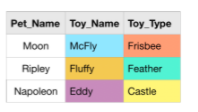

#Repeated data

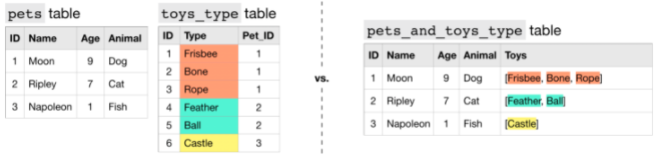

We say that the "Toys" column contains **repeated data**, because it permits more than one value for each row. This is reflected in the table schema, where the mode of the "Toys" column appears as **'REPEATED'**

Each entry in a repeated field is an **ARRAY**, or an ordered list of (zero or more) values with the same datatype. 

When querying repeated data, we need to put the name of the column containing the repeated data inside an **UNNEST**() function:

In [ ]:
query = """
        SELECT ID, 
               Name, 
               Age, 
               Animal,
               Toy_type
        FROM `bigquery-public-data.pet_records.pets_and_toys_type`,
          UNNEST(Toys) AS Toy_Type
        """

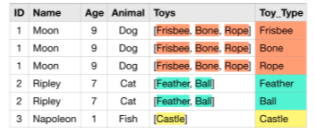

## Example

Now, let's considerer the table `languages` from `github_repos` dataset

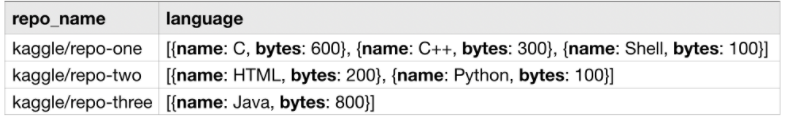

Write a query to leverage the information in the `languages` table to determine which programming `languages` appear in the most repositories. The table returned by your query should have two columns:

- `language_name` - the name of the programming language
- `num_repos` - the number of repositories in the `languages` table that use the programming language

Sort the table so that languages that appear in more repos are shown first.

In [ ]:
pop_lang_query = """
                SELECT l.name AS language_name,
                       COUNT(*) AS num_repos 
                FROM  `bigquery-public-data.github_repos.languages`,
                    UNNEST(language) as l
                GROUP BY language_name
                ORDER BY num_repos DESC
                """

# Writing efficient queries

## Comparing efficiency

We will use two functions to compare the efficiency of different queries:

- `show_amount_of_data_scanned()` shows the amount of data the query uses.
- `show_time_to_run()` prints how long it takes for the query to execute.

In [ ]:
from google.cloud import bigquery
from time import time

client = bigquery.Client()

def show_amount_of_data_scanned(query):
    # dry_run lets us see how much data the query uses without running it
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))